In [1]:
import warnings
warnings.filterwarnings('ignore')

### Импорт библиотек

In [2]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error

In [3]:
# Импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
# Импорт библиотеки кластеризации переменных
# https://pypi.org/project/varclushi/
from varclushi import VarClusHi

## Загрузка данных

In [5]:
# Указываем путь к файлу
# При работе с google colab существует 2 варианта загрузки файла:
# 1. Через google drive
# 2. Через левое меню: "файлы" -> "загрузить в сессионное хранилище" -> "скопировать файл" (при наведении на файл)
file_path = 'C:/Users/Frederik/Desktop/white_wine.csv'

In [6]:
# Загружаем данные из SAS файла
df = pd.read_csv(file_path)
df = df.astype('float')
# Пример данных
df.head()

,fixed acidity,volatile acidity,citric acid,sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target_quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


## Функции обработки

In [7]:
# Метод главных компонент
def pca_transform(X, transform = []):
    pca_model = PCA(n_components='mle')
    pca_model.fit(X)

    if transform == []:
        transform = [X]
    return [pca_model.transform(t) for t in transform]

In [8]:
# Кластеризация переменных
def variable_clustering(X, transform = []):
    var_clust_model = VarClusHi(X, maxeigval2 = .7, maxclus = None)
    var_clust_model.varclus()
    var_clust = var_clust_model.rsquare.loc[:, ["Cluster","Variable","RS_Ratio"]]
    vars = var_clust.sort_values("RS_Ratio").drop_duplicates(['Cluster'],keep='first')["Variable"].to_list()

    if transform == []:
        transform = [X]
    return [t.loc[:, vars] for t in transform]

In [9]:
# Разделение на обучающую, валидационную и тестовую выборку
def data_partition(X, y):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, stratify = y, test_size=0.6, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, stratify = y_test_val, test_size=0.5, random_state=42)
    return (X_train, y_train, X_val, y_val, X_test, y_test)

In [10]:
# Расчет ошибки прогнозирования
def score_model_mae(model, 
                    X_train, y_train,
                    X_val, y_val,
                    X_test, y_test):
    print(model.__class__.__name__)
    print("TRAIN MSE: {:f}".format(mean_squared_error(y_train, model.predict(X_train))))
    print("VAL MSE: {:f}".format(mean_squared_error(y_val, model.predict(X_val))))
    print("TEST MSE: {:f}".format(mean_squared_error(y_test, model.predict(X_test))))

## Формирование признакового пространства

In [11]:
# Сформируем признаковое пространство:
# Целевая переменная: target_quality. Описывает субъективную оценку качества сорта вина. 
# Остальные переменные - входные. 
# Задача – спрогнозировать оценку эксперта в зависимости от объективных химических показателей вина и выявить важные признаки
y = df["  target_quality   "].to_frame()
X = df.loc[:, list(set(df.columns) - {"  target_quality   "})]

# Дискретизация отклика
qtransform = QuantileTransformer(output_distribution='normal', n_quantiles = 5, random_state = 42)
y.values[:] = qtransform.fit_transform(y)

## Часть 1: KNN

In [12]:
from sklearn.neighbors import KNeighborsRegressor

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# Стандартизация
scaler = StandardScaler()
scaler.fit(X_train)
for X_ in (X_train, X_val, X_test):
    X_.values[:] = scaler.transform(X_)

# PCA или Variable clustring (вставьте свой код)


# KNN 
knn = KNeighborsRegressor(n_neighbors=20)
knn.fit(X_train, y_train)

# Score
score_model_mae(knn, X_train, y_train, X_val, y_val, X_test, y_test)

KNeighborsRegressor
TRAIN MSE: 0.385404
VAL MSE: 0.441951
TEST MSE: 0.402548


1. На тренировочном наборе данных было получено MSE 0.385404, на валидационном 0.441951, а на тестовом 0.402548.

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# Стандартизация
scaler = StandardScaler()
scaler.fit(X_train)
for X_ in (X_train, X_val, X_test):
    X_.values[:] = scaler.transform(X_)

# PCA или Variable clustring (вставьте свой код)
variables = variable_clustering(X_train)[0].columns
X_train = X_train[variables]
X_val = X_val[variables]
X_test = X_test[variables]

# KNN 
knn = KNeighborsRegressor(n_neighbors=20)
knn.fit(X_train, y_train)

# Score
score_model_mae(knn, X_train, y_train, X_val, y_val, X_test, y_test)

KNeighborsRegressor
TRAIN MSE: 0.413794
VAL MSE: 0.450412
TEST MSE: 0.432806


In [14]:
print("Количество переменных в исходном наборе данных:", len(X.columns))
print("Количество переменных после обработки:", len(variables))

Количество переменных в исходном наборе данных: 11
Количество переменных после обработки: 7


3. Количество переменных в исходном наборе данных было равно 11, в то время как количество переменных после обработки стало равно 7. После обработки, на тренировочном наборе данных было получено MSE 0.413794, на валидационном 0.450412, а на тестовом 0.432806. В результате данной обработки, значения MSE увеличились на всех наборах данных. Это может быть связано с тем, что среди убранных переменных были те переменные, которые несли в себе важную информацию и убрав эти переменные мы только ухудшили прогноз.

### Вопросы части 1:

1. Какие значения MSE получились на тренировочном, валидационном и тестовом наборе данных?
2. Перед применением KNN вставьте предобработку PCA (Вариант I), Variable clustering (Вариант II). 
3. Сколько переменных теперь передается на вход KNN? Как изменились значения MSE в результате? Почему это могло произойти?

## Часть 2: Regression

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
import statsmodels.api as sm
# Документация для OLS
# https://bookdown.org/mike/data_analysis/ordinary-least-squares.html

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

In [16]:
# Построим полиномиальную регрессию (degree = 2)

# Отобразмим пространство признаков в пространство полиномов степени 2
poly_reg = PolynomialFeatures(degree=2)
X_train = poly_reg.fit_transform(X_train)
X_val = poly_reg.transform(X_val)
X_test = poly_reg.transform(X_test)

In [1]:
# Определим лучшее число признаков с помощью Backward (измените код для отбора с помощью Forward)
best_feats = None
features = list(range(X_train.shape[1]))
errs = []
while len(features) > 0:
    lr = LinearRegression()
    lr.fit(X_train[:, features], y_train)
    err = mean_squared_error(y_val, lr.predict(X_val[:, features]))
    errs.append(err)
    if min(errs) == err:
        best_feats = features.copy()

    model = sm.OLS(y_train, X_train[:, features])
    res = model.fit()

    # Выбираем худший признак и удаляем из пространства признаков
    worse_feature = features[np.argmax(res.pvalues)]
    features.remove(worse_feature)

# Визуализируем ошибки
idx = len(errs) - len(best_feats)
plt.plot(errs)
plt.plot(idx, errs[idx], 'P', ms=10, mfc='red')
plt.xlabel("Номер итерации")
plt.ylabel("MSE")
plt.title("Ошибка при отборе признаков методом Backward")
plt.show()

# Обучим линейную регрессию на лучших признаках
lr = LinearRegression()
lr.fit(X_train[:, best_feats], y_train)

score_model_mae(lr, 
                X_train[:, best_feats], y_train, 
                X_val[:, best_feats], y_val, 
                X_test[:, best_feats], y_test)

NameError: name 'X_train' is not defined

1. Реализуем метод Forward

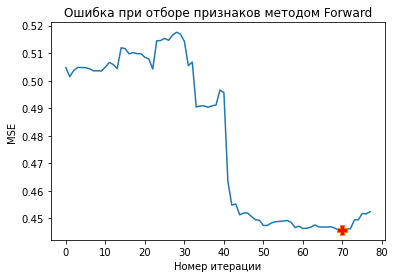

LinearRegression
TRAIN MSE: 0.377577
VAL MSE: 0.445842
TEST MSE: 0.391788


In [18]:
# Определим лучшее число признаков с помощью Forward
best_feats = None
init_features = list(range(X_train.shape[1]))
features = list()
errs = []

init_rss = 1

while len(init_features) > 0:
    best_rss = init_rss
    for i in range(len(init_features)):
        model = sm.OLS(y_train, X_train[:, init_features[i]])
        res = model.fit()
        if res.mse_resid <= best_rss:
            best_rss = res.mse_resid
            best_feature = i
    features.append(init_features[best_feature])
    init_features.remove(init_features[best_feature])
    
    lr = LinearRegression()
    lr.fit(X_train[:, features], y_train)
    err = mean_squared_error(y_val, lr.predict(X_val[:, features]))
    errs.append(err)
best_feats = features[:errs.index(min(errs))]

# Визуализируем ошибки
idx = len(best_feats)
plt.plot(errs)
plt.plot(idx, errs[idx], 'P', ms=10, mfc='red')
plt.xlabel("Номер итерации")
plt.ylabel("MSE")
plt.title("Ошибка при отборе признаков методом Forward")
plt.show()

# Обучим линейную регрессию на лучших признаках
lr = LinearRegression()
res = lr.fit(X_train[:, best_feats], y_train)

score_model_mae(lr, 
                X_train[:, best_feats], y_train, 
                X_val[:, best_feats], y_val, 
                X_test[:, best_feats], y_test)

2. На тестовом наборе лучшее качество демонстрирует метод Backward.

In [19]:
for j in [poly_reg.get_feature_names()[i] for i in features[errs.index(min(errs)):]]:
    if len(j) == 5:
        print(X.columns[int(j[1])], X.columns[int(j[4])])
    else:
        print(X.columns[int(j[1])], X.columns[int(j[1])])

  volatile acidity     chlorides  
  volatile acidity     total sulfur dioxide  
  sugar     total sulfur dioxide  
  sugar     sugar  
  chlorides     total sulfur dioxide  
  volatile acidity     volatile acidity  
  volatile acidity     sugar  
  chlorides     sugar  


3. Переменные, невошедшие в результирующую регрессионую модель: 


  chlorides     volatile acidity  
  total sulfur dioxide     volatile acidity  
  total sulfur dioxide     sugar  
  sugar     sugar  
  total sulfur dioxide     chlorides  
  volatile acidity     volatile acidity  
  sugar     volatile acidity  
  sugar     chlorides 

4. Лучшая модель была выбрана на 70 номере итерации, что несет в себе смысл 70 переменной в признаковом пространстве.

In [22]:
res = sm.OLS(y_train, X_train[:, best_feats]).fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:       target_quality      R-squared:                       0.357
Model:                             OLS   Adj. R-squared:                  0.333
Method:                  Least Squares   F-statistic:                     15.18
Date:                 Tue, 12 Apr 2022   Prob (F-statistic):          1.99e-134
Time:                         18:08:13   Log-Likelihood:                -1825.7
No. Observations:                 1959   AIC:                             3791.
Df Residuals:                     1889   BIC:                             4182.
Df Model:                           69                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0403      0.039      1.03

In [23]:
X.columns[int(poly_reg.get_feature_names()[list(res.pvalues).index(max(res.pvalues))][1])]

'fixed acidity  '

5. Основываясь на summary() наименее важная с точки зрения t-статистики переменная это 'fixed acidity  ' из-за наибольшего P-value.

6. Добавим MinMax стандартизацию.

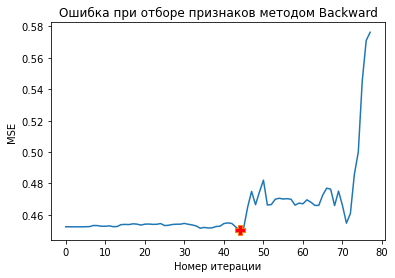

LinearRegression
TRAIN MSE: 0.378216
VAL MSE: 0.450466
TEST MSE: 0.390694


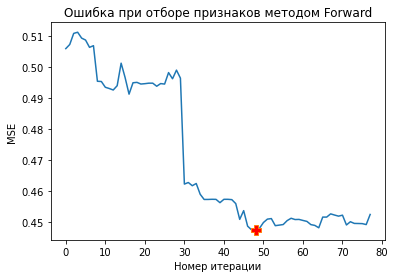

LinearRegression
TRAIN MSE: 0.396003
VAL MSE: 0.447473
TEST MSE: 0.418226


In [24]:
X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# MinMax стандартизация (вставьте свой код)
scaler = MinMaxScaler()
scaler.fit(X_train)
for X_ in (X_train, X_val, X_test):
    X_.values[:] = scaler.transform(X_)
# Построим полиномиальную регрессию (degree = 2)

# Отобразмим пространство признаков в пространство полиномов степени 2
poly_reg = PolynomialFeatures(degree=2)
X_train = poly_reg.fit_transform(X_train)
X_val = poly_reg.transform(X_val)
X_test = poly_reg.transform(X_test)

# Определим лучшее число признаков с помощью Backward (измените код для отбора с помощью Forward)
best_feats = None
features = list(range(X_train.shape[1]))
errs = []
while len(features) > 0:
    lr = LinearRegression()
    lr.fit(X_train[:, features], y_train)
    err = mean_squared_error(y_val, lr.predict(X_val[:, features]))
    errs.append(err)
    if min(errs) == err:
        best_feats = features.copy()

    model = sm.OLS(y_train, X_train[:, features])
    res = model.fit()

    # Выбираем худший признак и удаляем из пространства признаков
    worse_feature = features[np.argmax(res.pvalues)]
    features.remove(worse_feature)

# Визуализируем ошибки
idx = len(errs) - len(best_feats)
plt.plot(errs)
plt.plot(idx, errs[idx], 'P', ms=10, mfc='red')
plt.xlabel("Номер итерации")
plt.ylabel("MSE")
plt.title("Ошибка при отборе признаков методом Backward")
plt.show()

# Обучим линейную регрессию на лучших признаках
lr = LinearRegression()
lr.fit(X_train[:, best_feats], y_train)

score_model_mae(lr, 
                X_train[:, best_feats], y_train, 
                X_val[:, best_feats], y_val, 
                X_test[:, best_feats], y_test)



# Определим лучшее число признаков с помощью Forward
best_feats = None
init_features = list(range(X_train.shape[1]))
features = list()
errs = []

init_rss = 1

while len(init_features) > 0:
    best_rss = init_rss
    for i in range(len(init_features)):
        model = sm.OLS(y_train, X_train[:, init_features[i]])
        res = model.fit()
        if res.mse_resid <= best_rss:
            best_rss = res.mse_resid
            best_feature = i
    features.append(init_features[best_feature])
    init_features.remove(init_features[best_feature])
    
    lr = LinearRegression()
    lr.fit(X_train[:, features], y_train)
    err = mean_squared_error(y_val, lr.predict(X_val[:, features]))
    errs.append(err)
best_feats = features[:errs.index(min(errs))]

# Визуализируем ошибки
idx = len(best_feats)
plt.plot(errs)
plt.plot(idx, errs[idx], 'P', ms=10, mfc='red')
plt.xlabel("Номер итерации")
plt.ylabel("MSE")
plt.title("Ошибка при отборе признаков методом Forward")
plt.show()

# Обучим линейную регрессию на лучших признаках
lr = LinearRegression()
res = lr.fit(X_train[:, best_feats], y_train)

score_model_mae(lr, 
                X_train[:, best_feats], y_train, 
                X_val[:, best_feats], y_val, 
                X_test[:, best_feats], y_test)

MinMax стандартизация уменьшила точность на тестовом наборе на методе Backward и уменьшила на методе Forward. Число степеней свободы уменьшилось на 22, так как в финальный набор переменных не вошло 22 переменных.

In [25]:
print(sm.OLS(y_train, X_train[:, best_feats]).fit().summary())

                             OLS Regression Results                            
Dep. Variable:       target_quality      R-squared:                       0.325
Model:                             OLS   Adj. R-squared:                  0.309
Method:                  Least Squares   F-statistic:                     19.61
Date:                 Tue, 12 Apr 2022   Prob (F-statistic):          1.57e-129
Time:                         18:08:39   Log-Likelihood:                -1872.4
No. Observations:                 1959   AIC:                             3841.
Df Residuals:                     1911   BIC:                             4109.
Df Model:                           47                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.9388      0.715     -1.31

### Вопросы к части 2:

1. Аналогично алгоритму выбора признаков Backward, опишите алгоритм Forward
2. Какая модель показывает лучшее качество на тестовом наборе? 
3. Какие переменные не вошли в результирующую регрессионую модель? 
4. На каком шаге была выбрана лучшая модель?
5. С помощью summary() определите какая из вошедших переменных наименее важная с точки зрения t-статистики?

5. После разделения данных добавьте MinMaxScaler. Как изменились результаты регрессионной модели с точки числа степеней свободы и значения MSE на тестовом наборе?

## Часть 3: PLS/PCR

In [26]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# Метод PCR представляем в виде комбинации PCA с последующей линейной регрессией
pcr = make_pipeline(PCA(n_components=5), LinearRegression())
pcr.fit(X_train, y_train)

pls = PLSRegression(n_components=5)
pls.fit(X_train, y_train)

# MSE
score_model_mae(pcr, X_train, y_train, X_val, y_val, X_test, y_test)
score_model_mae(pls, X_train, y_train, X_val, y_val, X_test, y_test)

Pipeline
TRAIN MSE: 0.477364
VAL MSE: 0.496493
TEST MSE: 0.471302
PLSRegression
TRAIN MSE: 0.441024
VAL MSE: 0.464150
TEST MSE: 0.445547


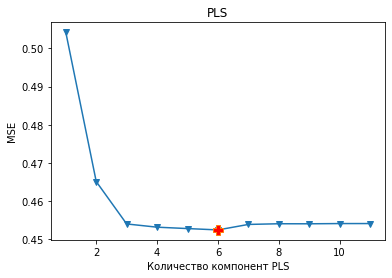

In [27]:
# Необходимо определить лучшее количество компонент

def optimise_comp_cv(X, y, n_comp):
    # Определяем модель (PLS или PCR)
    pls = PLSRegression(n_components=n_comp)

    # Расчет ошибки на кросс-валидации
    y_cv = cross_val_predict(pls, X, y, cv=10)
    mse = mean_squared_error(y, y_cv)
    return mse

# Визуализация MSE
def plot_metrics(vals, ylabel, objective, xticks):
    plt.plot(xticks, np.array(vals), '-v')
    if objective=='min':
        idx = np.argmin(vals)
    else:
        idx = np.argmax(vals)
    plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

    plt.xlabel('Количество компонент PLS')
    plt.xticks = xticks
    plt.ylabel(ylabel)
    plt.title('PLS')
    plt.show()


# Кросс-валидация проводится на обучающей и валидационной выборках
X_tr_val = pd.concat([X_train, X_val])
y_tr_val = pd.concat([y_train, y_val])
mses = []
list_components = list(range(1, X_tr_val.shape[1]+1))
for n_comp in list_components:
    mse = optimise_comp_cv(X_tr_val, y_tr_val, n_comp)
    mses.append(mse)
plot_metrics(mses, 'MSE', 'min', list_components)

### Вопросы к части 3:

1. Сколько компонент было выбрано для моделей PCR и PLS?
2. Какое значение MSE модели показывают на тестовом наборе?

1. В модели PCR было выбрано 5 компонент, в то время как в методе PLS было выбрано 6 компонент.

2. Модель PCR на тестовом наборе показывает MSE равное 0.4713. Модель PLS показывает точность 0.445. 

## Часть 4: LARS + LASSO

In [28]:
# Документация LARS+LASSO
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsIC.html#sklearn.linear_model.LassoLarsIC

from sklearn.linear_model import LassoLarsIC

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

X_tr_val = pd.concat([X_train, X_val])
y_tr_val = pd.concat([y_train, y_val])
reg = LassoLarsIC(criterion='aic', normalize=True)
reg.fit(X_tr_val, y_tr_val)

score_model_mae(reg, X_train, y_train, X_val, y_val, X_test, y_test)

LassoLarsIC
TRAIN MSE: 0.440585
VAL MSE: 0.456414
TEST MSE: 0.438269


### Вопросы к части 4:

1. Какое значение MSE модель показывает на тестовом наборе? 
2. Какая пременная была отобрана на первом шаге? 
3. Сколько всего переменных было отобрано?
4. Если бы вместо критерия отбора модели вашего варианта использовался критерий MSE на валидационном наборе, то было бы отобрано больше или меньше переменных?

1. На тестовом наборе была показана точность 0.438269.

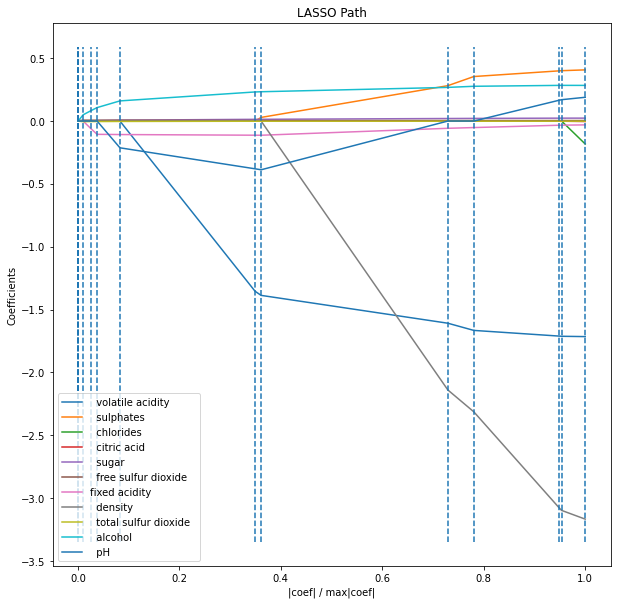

In [30]:
from sklearn import linear_model

X_array = np.array(X_tr_val)
Y_array = np.array(y_tr_val).flatten()

alphas, _, coefs = linear_model.lars_path(X_array, Y_array, method="lasso")

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10, 10))
plt.plot(xx, coefs.T, label=X_tr_val.columns)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle="dashed")
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.axis("tight")
plt.legend()
plt.show()

In [31]:
X_tr_val.columns[np.argmax(coefs.T[1])]

'  total sulfur dioxide  '

2. В качестве первой переменной была отобрана "total sulfur dioxide".

In [32]:
len(reg.coef_[reg.coef_ != 0])

11

3. Все переменные (11) имеют ненулевые коэффициенты, а значит все отобраны в модель.

In [33]:
errors = []
for i in range(len(coefs.T)):
    current_coefs = coefs.T[i]
    current_alpha = alphas[i]
    lm = linear_model.Lasso(alpha=current_alpha)
    lm.coef_ = current_coefs
    lm.intercept_ = 0
    errors.append(mean_squared_error(y_val, lm.predict(X_val)))

In [34]:
len(coefs.T[errors.index(min(errors))][coefs.T[errors.index(min(errors))] != 0])

8

4. Построив модели на основе параметров моделей на каждом шагу и найдя среди них модель с минимальной ошибкой на валидационном наборе было обнаружено, что эта модель обладает только 8 коэффициентами неравными 0. А значит число переменных в этой модели равно 8.

## Общие вопросы:

1. Зачем при разделении выборкок проводится стратификация по целевой переменной?
2. Какая модель показала лучшее значение MSE на тестовой выборке?

1. Для того, чтобы сохранить распределение целевой переменной в каждой выборке. Иначе распределение может различаться, что приведет к неправильному обучению. Например, в обучающей выборке распределение целевой переменной получилось равномерным, а в тестовой оно является нормальным.

2. Лучший результат получился на полиномиальной регрессии с методом отбора компонент Backward.